## Some warnings
This notebook is just a copy from [Tutorial: From Convey to Lenia](https://colab.research.google.com/github/OpenLenia/Lenia-Tutorial/blob/main/Tutorial_From_Conway_to_Lenia_(w_o_results).ipynb#scrollTo=YT-o59M7Q-53) by [Bert Chan](https://twitter.com/BertChakovsky).

# Common stuff
Load Python libraries, define settings and utility functions.

In [2]:
%matplotlib inline
import numpy as np
import scipy.signal
import matplotlib.pylab as plt
import matplotlib.animation
import IPython.display
import warnings

warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

# default values
R = 1

def figure_world(A, cmap='viridis'):
  global img
  fig = plt.figure()
  img = plt.imshow(A, cmap=cmap, interpolation="nearest", vmin=0)
  plt.title('world A')
  plt.close()
  return fig

def figure_asset(K, growth, cmap='viridis', K_sum=1, bar_K=False):
  global R
  K_size = K.shape[0];  K_mid = K_size // 2
  fig, ax = plt.subplots(1, 3, figsize=(14,2), gridspec_kw={'width_ratios': [1,1,2]})
  ax[0].imshow(K, cmap=cmap, interpolation="nearest", vmin=0)
  ax[0].title.set_text('kernel K')
  if bar_K:
    ax[1].bar(range(K_size), K[K_mid,:], width=1)
  else:
    ax[1].plot(range(K_size), K[K_mid,:])
  ax[1].title.set_text('K cross-section')
  ax[1].set_xlim([K_mid - R - 3, K_mid + R + 3])
  if K_sum <= 1:
    x = np.linspace(0, K_sum, 1000)
    ax[2].plot(x, growth(x))
  else:
    x = np.arange(K_sum + 1)
    ax[2].step(x, growth(x))
  ax[2].axhline(y=0, color='grey', linestyle='dotted')
  ax[2].title.set_text('growth G')
  return fig

def figure_asset_list(Ks, nKs, growth, kernels, use_c0=False, cmap='viridis', K_sum=1):
  global R
  K_size = Ks[0].shape[0];  K_mid = K_size // 2
  fig, ax = plt.subplots(1, 3, figsize=(14,2), gridspec_kw={'width_ratios': [1,2,2]})
  if use_c0:
    K_stack = [ np.clip(np.zeros(Ks[0].shape) + sum(K/3 for k,K in zip(kernels,Ks) if k['c0']==l), 0, 1) for l in range(3) ]
  else:
    K_stack = Ks[:3]
  ax[0].imshow(np.dstack(K_stack), cmap=cmap, interpolation="nearest", vmin=0)
  ax[0].title.set_text('kernels Ks')
  X_stack = [ K[K_mid,:] for K in nKs ]
  ax[1].plot(range(K_size), np.asarray(X_stack).T)
  ax[1].title.set_text('Ks cross-sections')
  ax[1].set_xlim([K_mid - R - 3, K_mid + R + 3])
  x = np.linspace(0, K_sum, 1000)
  G_stack = [ growth(x, k['m'], k['s']) * k['h'] for k in kernels ]
  ax[2].plot(x, np.asarray(G_stack).T)
  ax[2].axhline(y=0, color='grey', linestyle='dotted')
  ax[2].title.set_text('growths Gs')
  return fig

def figure_panels(As, Ks, cmap='viridis'):
  global img1, img2, img3, img4
  A_size = As[0].shape[0]
  K_stack = [ np.clip(np.zeros(Ks[0].shape) + sum(K/3 for k,K in zip(kernels,Ks) if k['c0']==l), 0, 1) for l in range(3) ]
  fig = plt.figure(figsize=(8,8), dpi=75, frameon=False)
  plt.subplot(221).set_axis_off();  img1 = plt.imshow(np.dstack(As), vmin=0)
  plt.subplot(222).set_axis_off();  img2 = plt.imshow(np.dstack([np.zeros([A_size, A_size])]*3), vmin=0)
  plt.subplot(223).set_axis_off();  img3 = plt.imshow(np.dstack([np.zeros([A_size, A_size])]*3), vmin=0)
  plt.subplot(224).set_axis_off();  img4 = plt.imshow(np.dstack(K_stack), vmin=0)
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
  plt.close()
  return fig


# Sample creatures

Instead of initializing random worlds, we can load sample creatures that are stable in behavior.

In [3]:
pattern = {}
pattern["bosco"] = {"name":"Bosco","R":5,"b1":34,"b2":45,"s1":34,"s2":58,
  "cells":[[0,0,0,0,1,0,0,0,0,0], [0,0,1,1,1,1,1,0,0,0], [0,1,1,0,0,1,1,1,1,0], [1,1,0,0,0,1,1,1,1,1], [1,0,0,0,0,0,1,1,1,1], [1,1,0,0,0,0,1,1,1,1], [1,1,1,0,1,1,1,1,1,1], [0,1,1,1,1,1,1,1,1,0], [0,1,1,1,1,1,1,1,0,0], [0,0,1,1,1,1,1,0,0,0], [0,0,0,1,1,1,0,0,0,0]]
}

pattern["orbium"] = {"name":"Orbium","R":13,"T":10,"m":0.15,"s":0.015,"b":[1],
  "cells":[[0,0,0,0,0,0,0.1,0.14,0.1,0,0,0.03,0.03,0,0,0.3,0,0,0,0], [0,0,0,0,0,0.08,0.24,0.3,0.3,0.18,0.14,0.15,0.16,0.15,0.09,0.2,0,0,0,0], [0,0,0,0,0,0.15,0.34,0.44,0.46,0.38,0.18,0.14,0.11,0.13,0.19,0.18,0.45,0,0,0], [0,0,0,0,0.06,0.13,0.39,0.5,0.5,0.37,0.06,0,0,0,0.02,0.16,0.68,0,0,0], [0,0,0,0.11,0.17,0.17,0.33,0.4,0.38,0.28,0.14,0,0,0,0,0,0.18,0.42,0,0], [0,0,0.09,0.18,0.13,0.06,0.08,0.26,0.32,0.32,0.27,0,0,0,0,0,0,0.82,0,0], [0.27,0,0.16,0.12,0,0,0,0.25,0.38,0.44,0.45,0.34,0,0,0,0,0,0.22,0.17,0], [0,0.07,0.2,0.02,0,0,0,0.31,0.48,0.57,0.6,0.57,0,0,0,0,0,0,0.49,0], [0,0.59,0.19,0,0,0,0,0.2,0.57,0.69,0.76,0.76,0.49,0,0,0,0,0,0.36,0], [0,0.58,0.19,0,0,0,0,0,0.67,0.83,0.9,0.92,0.87,0.12,0,0,0,0,0.22,0.07], [0,0,0.46,0,0,0,0,0,0.7,0.93,1,1,1,0.61,0,0,0,0,0.18,0.11], [0,0,0.82,0,0,0,0,0,0.47,1,1,0.98,1,0.96,0.27,0,0,0,0.19,0.1], [0,0,0.46,0,0,0,0,0,0.25,1,1,0.84,0.92,0.97,0.54,0.14,0.04,0.1,0.21,0.05], [0,0,0,0.4,0,0,0,0,0.09,0.8,1,0.82,0.8,0.85,0.63,0.31,0.18,0.19,0.2,0.01], [0,0,0,0.36,0.1,0,0,0,0.05,0.54,0.86,0.79,0.74,0.72,0.6,0.39,0.28,0.24,0.13,0], [0,0,0,0.01,0.3,0.07,0,0,0.08,0.36,0.64,0.7,0.64,0.6,0.51,0.39,0.29,0.19,0.04,0], [0,0,0,0,0.1,0.24,0.14,0.1,0.15,0.29,0.45,0.53,0.52,0.46,0.4,0.31,0.21,0.08,0,0], [0,0,0,0,0,0.08,0.21,0.21,0.22,0.29,0.36,0.39,0.37,0.33,0.26,0.18,0.09,0,0,0], [0,0,0,0,0,0,0.03,0.13,0.19,0.22,0.24,0.24,0.23,0.18,0.13,0.05,0,0,0,0], [0,0,0,0,0,0,0,0,0.02,0.06,0.08,0.09,0.07,0.05,0.01,0,0,0,0,0]]
}

pattern["geminium"] = {"name":"Hydrogeminium","R":18,"T":10,"m":0.26,"s":0.036,"b":[0.5,1,0.667],
  "cells":[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.02,0.03,0.04,0.04,0.04,0.03,0.02,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.1,0.16,0.2,0.23,0.25,0.24,0.21,0.18,0.14,0.1,0.07,0.03,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.09,0.2,0.33,0.44,0.52,0.56,0.58,0.55,0.51,0.44,0.37,0.3,0.23,0.16,0.08,0.01,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.13,0.29,0.45,0.6,0.75,0.85,0.9,0.91,0.88,0.82,0.74,0.64,0.55,0.46,0.36,0.25,0.12,0.03,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.38,0.6,0.78,0.93,1.0,1.0,1.0,1.0,1.0,1.0,0.99,0.89,0.78,0.67,0.56,0.44,0.3,0.15,0.04,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08,0.39,0.74,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.85,0.74,0.62,0.47,0.3,0.14,0.03,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,0.76,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.88,0.75,0.61,0.45,0.27,0.11,0.01,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.35,0.83,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.88,0.73,0.57,0.38,0.19,0.05,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,1.0,1.0,0.85,0.67,0.47,0.27,0.11,0.01], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.55,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.83,0.79,0.84,0.88,0.89,0.9,0.93,0.98,1.0,1.0,1.0,1.0,0.98,0.79,0.57,0.34,0.15,0.03], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.47,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9,0.72,0.54,0.44,0.48,0.6,0.7,0.76,0.82,0.91,0.99,1.0,1.0,1.0,1.0,0.91,0.67,0.41,0.19,0.05], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.27,0.99,1.0,1.0,1.0,1.0,0.9,0.71,0.65,0.55,0.38,0.2,0.14,0.21,0.36,0.52,0.64,0.73,0.84,0.95,1.0,1.0,1.0,1.0,1.0,0.78,0.49,0.24,0.07], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.63,0.96,1.0,1.0,1.0,0.84,0.17,0,0,0,0,0,0,0,0.13,0.35,0.51,0.64,0.77,0.91,0.99,1.0,1.0,1.0,1.0,0.88,0.58,0.29,0.09], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0.38,0.72,0.95,1.0,1.0,1.0,0.22,0,0,0,0,0,0,0,0,0,0.11,0.33,0.5,0.67,0.86,0.99,1.0,1.0,1.0,1.0,0.95,0.64,0.33,0.1], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,0.49,0.71,0.93,1.0,1.0,1.0,0.56,0,0,0,0,0,0,0,0,0,0,0,0.1,0.31,0.52,0.79,0.98,1.0,1.0,1.0,1.0,0.98,0.67,0.35,0.11], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.6,0.83,0.98,1.0,1.0,0.68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15,0.38,0.71,0.97,1.0,1.0,1.0,1.0,0.97,0.67,0.35,0.11], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.51,0.96,1.0,1.0,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.09,0.34,0.68,0.95,1.0,1.0,1.0,1.0,0.91,0.61,0.32,0.1], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.13,0.56,0.99,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17,0.45,0.76,0.96,1.0,1.0,1.0,1.0,0.82,0.52,0.26,0.07], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.7,0.94,1.0,1.0,0.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.68,0.91,0.99,1.0,1.0,1.0,1.0,0.71,0.42,0.19,0.03], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.53,0.89,1.0,1.0,1.0,0.8,0.43,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.47,0.86,1.0,1.0,1.0,1.0,1.0,0.95,0.58,0.32,0.12,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.77,0.99,1.0,0.97,0.58,0.41,0.33,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.54,0.95,1.0,1.0,1.0,1.0,1.0,0.8,0.44,0.21,0.06,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.39,0.83,1.0,1.0,0.55,0.11,0.05,0.15,0.22,0.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.58,0.99,1.0,1.0,1.0,1.0,1.0,0.59,0.29,0.11,0.01,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.55,0.81,0.86,0.97,1.0,1.0,0.5,0,0,0.01,0.09,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0.26,0.78,1.0,1.0,1.0,1.0,1.0,0.66,0.35,0.13,0.03,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.23,0.73,0.95,1.0,1.0,1.0,1.0,1.0,0.62,0.35,0.12,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.51,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.56,0.25,0.09,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.12,0.38,1.0,1.0,1.0,0.66,0.08,0.55,1.0,1.0,1.0,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0.35,1.0,1.0,1.0,1.0,1.0,1.0,0.67,0.12,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.6,1.0,1.0,1.0,1.0,1.0,1.0,0.49,0,0,0.87,1.0,0.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.7,0.07,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.04,0.21,0.48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.04,0.42,0.26,0,0,0,0,0,0,0,0,0,0.12,0.21,0.34,0.58,1.0,1.0,1.0,0.99,0.97,0.99,0.46,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.5,1.0,1.0,1.0,1.0,0.96,0,0.31,1.0,1.0,1.0,0.53,0,0,0,0,0,0,0,0,0.2,0.21,0,0,0,0.27,1.0,1.0,1.0,1.0,1.0,1.0,0.87,0.52,0.01,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.84,1.0,1.0,1.0,1.0,1.0,0,0,0,0.83,1.0,1.0,0.52,0,0,0,0,0,0,0,0.26,0.82,0.59,0.02,0,0,0.46,1.0,1.0,1.0,1.0,1.0,0.9,0.55,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.39,0.99,1.0,1.0,1.0,1.0,0.78,0.04,0,0,0,0.93,0.92,0,0,0,0,0,0,0,0,0.69,1.0,1.0,0.36,0,0,1.0,1.0,0.65,0.66,0.97,0.87,0.54,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.55,0.75,0.59,0.74,1.0,1.0,0,0,0.75,0.71,0.18,0,0,0,0,0,0,0,0,0,0,0.29,0,0,0.45,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.47,0.39,0.71,0.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.69,0.81,0.8,0.92,1.0,0.13,0,0,0.13,0.94,0.58,0,0,0,0,0,0,0,0,0,1.0,1.0,0.34,0,0.04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.63,0.85,0.9,0.98,1.0,0.09,0,0,0.02,1.0,0.64,0,0,0,0,0,0,0,0,0.59,1.0,1.0,0.84,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.64,0.65,0.67,1.0,1.0,0.21,0.01,0,0.04,0.02,0,0,0,0,0,0,0,0,0,0.69,1.0,1.0,1.0,0.29,0.37,1.0,1.0,0.6,0.63,1.0,0.84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.44,0.73,0.73,0.85,1.0,0.97,0.23,0.05,0,0,0,0,0,0,0,0,0.06,0,0,0,0.97,1.0,1.0,1.0,1.0,1.0,1.0,0.33,0.24,0.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.12,0.55,0.9,0.9,1.0,1.0,1.0,0.43,0.04,0,0,0,0,0,0,0,0.31,0.54,0,0,0,0.88,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.29,0.71,1.0,1.0,1.0,1.0,0.79,0.28,0,0,0,0,0,0,0,0,0.4,0.77,0.54,0,0,0.87,1.0,1.0,1.0,1.0,1.0,0.31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0.16,0.27,0.41,0.72,0.99,1.0,1.0,0.82,0.42,0.09,0,0,0,0,0,0,0,0,0.1,0.55,0.58,0.58,0.77,0.99,1.0,1.0,1.0,1.0,0.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0.31,0.48,0.45,0.46,0.63,0.88,1.0,0.83,0.59,0.28,0.06,0,0,0,0,0,0,0,0,0,0.32,0.7,0.95,1.0,1.0,1.0,1.0,0.7,0.58,0.12,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0.23,0.54,0.53,0.48,0.57,0.59,0.65,0.63,0.55,0.35,0.13,0.03,0.02,0.09,0.74,1.0,0.09,0,0,0,0.32,0.86,1.0,1.0,1.0,1.0,0.57,0.44,0.31,0.16,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0.31,0.45,0.31,0.18,0.28,0.39,0.47,0.54,0.5,0.35,0.2,0.16,0.28,0.75,1.0,0.42,0.01,0,0,0.6,1.0,1.0,1.0,1.0,0.51,0.29,0.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.14,0.3,0.4,0.54,0.71,0.74,0.65,0.49,0.35,0.27,0.47,0.6,0.6,0.72,0.98,1.0,1.0,1.0,1.0,0.65,0.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.06,0.33,0.53,0.69,0.94,0.99,1.0,0.84,0.41,0.16,0.15,0.96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.73,0.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.42,0.86,0.98,0.98,0.99,1.0,0.94,0.63,0.32,0.62,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.65,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.07,0.62,0.95,1.0,1.0,0.99,0.98,0.99,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.03,0.46,0.89,1.0,1.0,0.97,0.83,0.75,0.81,0.94,1.0,1.0,1.0,1.0,0.99,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.14,0.57,0.88,0.93,0.81,0.58,0.45,0.48,0.64,0.86,0.97,0.99,0.99,0.42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.23,0.45,0.47,0.39,0.29,0.19,0.2,0.46,0.28,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.08,0.22,0.24,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.07,0.22,0.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
}

pattern["fish"] = {"name":"K=3 Fish","R":10,"T":5,"kernels":[
  {"b":[1,5/12,2/3],"m":0.156,"s":0.0118,"h":1,"c0":0,"c1":0},
  {"b":[1/12,1],"m":0.193,"s":0.049,"h":1,"c0":0,"c1":0},
  {"b":[1],"m":0.342,"s":0.0891,"h":1,"c0":0,"c1":0}],
  "cells":[[0,0,0,0,0,0,0,0,0,0,0,0.06,0.1,0.04,0.02,0.01,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.15,0.37,0.5,0.44,0.19,0.23,0.3,0.23,0.15,0.01,0,0,0,0], [0,0,0,0,0,0,0.32,0.78,0.26,0,0.11,0.11,0.1,0.08,0.18,0.16,0.17,0.24,0.09,0,0,0], [0,0,0,0,0.45,0.16,0,0,0,0,0,0.15,0.15,0.16,0.15,0.1,0.09,0.21,0.24,0.12,0,0], [0,0,0,0.1,0,0,0,0,0,0,0,0.17,0.39,0.43,0.34,0.25,0.15,0.16,0.15,0.25,0.03,0], [0,0.15,0.06,0,0,0,0,0,0,0,0.24,0.72,0.92,0.85,0.61,0.47,0.39,0.27,0.12,0.18,0.17,0], [0,0.08,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,0.73,0.6,0.56,0.31,0.12,0.15,0.24,0.01], [0,0.16,0,0,0,0,0,0,0,0.76,1.0,1.0,1.0,1.0,0.76,0.72,0.65,0.39,0.1,0.17,0.24,0.05], [0,0.05,0,0,0,0,0,0,0.21,0.83,1.0,1.0,1.0,1.0,0.86,0.85,0.76,0.36,0.17,0.13,0.21,0.07], [0,0.05,0,0,0.02,0,0,0,0.4,0.91,1.0,1.0,1.0,1.0,1.0,0.95,0.79,0.36,0.21,0.09,0.18,0.04], [0.06,0.08,0,0.18,0.21,0.1,0.03,0.38,0.92,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0.31,0.12,0.07,0.25,0], [0.05,0.12,0.27,0.4,0.34,0.42,0.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.97,0.33,0.16,0.05,0.1,0.26,0], [0,0.25,0.21,0.39,0.99,1.0,1.0,1.0,1.0,1.0,1.0,0.86,0.89,0.94,0.83,0.13,0,0,0.04,0.21,0.18,0], [0,0.06,0.29,0.63,0.84,0.97,1.0,1.0,1.0,0.96,0.46,0.33,0.36,0,0,0,0,0,0.03,0.35,0,0], [0,0,0.13,0.22,0.59,0.85,0.99,1.0,0.98,0.25,0,0,0,0,0,0,0,0,0.34,0.14,0,0], [0,0,0,0,0.33,0.7,0.95,0.8,0.33,0.11,0,0,0,0,0,0,0,0.11,0.26,0,0,0], [0,0,0,0,0.16,0.56,0.52,0.51,0.4,0.18,0.01,0,0,0,0,0,0,0.42,0,0,0,0], [0,0,0,0,0.01,0,0.33,0.47,0.33,0.05,0,0,0,0,0,0,0.35,0,0,0,0,0], [0,0,0,0,0,0.26,0.32,0.13,0,0,0,0,0,0,0,0.34,0,0,0,0,0,0], [0,0,0,0,0,0.22,0.25,0.03,0,0,0,0,0,0,0.46,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.09,0.2,0.22,0.23,0.23,0.22,0.3,0.3,0,0,0,0,0,0,0,0]]
}

pattern["aquarium"] = {"name":"Tessellatium gyrans","R":12,"T":2,"kernels":[
  {"b":[1],"m":0.272,"s":0.0595,"h":0.138,"r":0.91,"c0":0,"c1":0},
  {"b":[1],"m":0.349,"s":0.1585,"h":0.48,"r":0.62,"c0":0,"c1":0},
  {"b":[1,1/4],"m":0.2,"s":0.0332,"h":0.284,"r":0.5,"c0":0,"c1":0},
  {"b":[0,1],"m":0.114,"s":0.0528,"h":0.256,"r":0.97,"c0":1,"c1":1},
  {"b":[1],"m":0.447,"s":0.0777,"h":0.5,"r":0.72,"c0":1,"c1":1},
  {"b":[5/6,1],"m":0.247,"s":0.0342,"h":0.622,"r":0.8,"c0":1,"c1":1},
  {"b":[1],"m":0.21,"s":0.0617,"h":0.35,"r":0.96,"c0":2,"c1":2},
  {"b":[1],"m":0.462,"s":0.1192,"h":0.218,"r":0.56,"c0":2,"c1":2},
  {"b":[1],"m":0.446,"s":0.1793,"h":0.556,"r":0.78,"c0":2,"c1":2},
  {"b":[11/12,1],"m":0.327,"s":0.1408,"h":0.344,"r":0.79,"c0":0,"c1":1},
  {"b":[3/4,1],"m":0.476,"s":0.0995,"h":0.456,"r":0.5,"c0":0,"c1":2},
  {"b":[11/12,1],"m":0.379,"s":0.0697,"h":0.67,"r":0.72,"c0":1,"c1":0},
  {"b":[1],"m":0.262,"s":0.0877,"h":0.42,"r":0.68,"c0":1,"c1":2},
  {"b":[1/6,1,0],"m":0.412,"s":0.1101,"h":0.43,"r":0.82,"c0":2,"c1":0},
  {"b":[1],"m":0.201,"s":0.0786,"h":0.278,"r":0.82,"c0":2,"c1":1}],
  "cells":[
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.49,1.0,0,0.03,0.49,0.49,0.28,0.16,0.03,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.6,0.47,0.31,0.58,0.51,0.35,0.28,0.22,0,0,0,0,0], [0,0,0,0,0,0,0.15,0.32,0.17,0.61,0.97,0.29,0.67,0.59,0.88,1.0,0.92,0.8,0.61,0.42,0.19,0,0,0], [0,0,0,0,0,0,0,0.25,0.64,0.26,0.92,0.04,0.24,0.97,1.0,1.0,1.0,1.0,0.97,0.71,0.33,0.12,0,0], [0,0,0,0,0,0,0,0.38,0.84,0.99,0.78,0.67,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.95,0.62,0.37,0,0], [0,0,0,0,0.04,0.11,0,0.69,0.75,0.75,0.91,1.0,1.0,0.89,1.0,1.0,1.0,1.0,1.0,1.0,0.81,0.42,0.07,0], [0,0,0,0,0.44,0.63,0.04,0,0,0,0.11,0.14,0,0.05,0.64,1.0,1.0,1.0,1.0,1.0,0.92,0.56,0.23,0], [0,0,0,0,0.11,0.36,0.35,0.2,0,0,0,0,0,0,0.63,1.0,1.0,1.0,1.0,1.0,0.96,0.49,0.26,0], [0,0,0,0,0,0.4,0.37,0.18,0,0,0,0,0,0.04,0.41,0.52,0.67,0.82,1.0,1.0,0.91,0.4,0.23,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0.05,0.45,0.89,1.0,0.66,0.35,0.09,0], [0,0,0.22,0,0,0,0.05,0.36,0.6,0.13,0.02,0.04,0.24,0.34,0.1,0,0.04,0.62,1.0,1.0,0.44,0.25,0,0], [0,0,0,0.43,0.53,0.58,0.78,0.9,0.96,1.0,1.0,1.0,1.0,0.71,0.46,0.51,0.81,1.0,1.0,0.93,0.19,0.06,0,0], [0,0,0,0,0.23,0.26,0.37,0.51,0.71,0.89,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.42,0.06,0,0,0], [0,0,0,0,0.03,0,0,0.11,0.35,0.62,0.81,0.93,1.0,1.0,1.0,1.0,1.0,0.64,0.15,0,0,0,0,0], [0,0,0,0,0,0,0.06,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.05,0.09,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.28,0.42,0.44,0.34,0.18,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.34,1.0,1.0,1.0,1.0,1.0,0.91,0.52,0.14,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.17,0.75,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.35,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.22,0.92,1.0,1.0,1.0,1.0,1.0,1.0,0.59,0.09], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.75,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.71,0.16], [0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.67,0.83,0.85,1.0,1.0,1.0,1.0,1.0,1.0,0.68,0.17], [0,0,0,0,0,0,0,0,0,0,0,0,0.21,0.04,0.12,0.58,0.95,1.0,1.0,1.0,1.0,1.0,0.57,0.13], [0,0,0,0,0,0,0,0,0,0,0,0.07,0,0,0,0.2,0.64,0.96,1.0,1.0,1.0,0.9,0.24,0.01], [0,0,0,0,0,0,0,0,0,0,0.13,0.29,0,0,0,0.25,0.9,1.0,1.0,1.0,1.0,0.45,0.05,0], [0,0,0,0,0,0,0,0,0,0,0.13,0.31,0.07,0,0.46,0.96,1.0,1.0,1.0,1.0,0.51,0.12,0,0], [0,0,0,0,0,0,0,0,0.26,0.82,1.0,0.95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3,0.05,0,0,0], [0,0,0,0,0,0,0,0,0.28,0.74,1.0,0.95,0.87,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.07,0.69,1.0,1.0,1.0,1.0,1.0,0.96,0.25,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.4,0.72,0.9,0.83,0.7,0.56,0.43,0.14,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.25,0.37,0.44,0.37,0.24,0.11,0.04,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.75,0.4,0.15,0,0,0,0], [0,0,0,0,0,0,0,0,0.14,0.48,0.83,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0,0,0,0], [0,0,0,0,0,0,0,0,0.62,0.78,0.94,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0,0,0,0], [0,0,0,0,0,0,0,0.02,0.65,0.98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.78,0,0,0,0], [0,0,0,0,0,0,0,0.15,0.48,0.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.79,0.05,0,0,0], [0,0,0,0,0,0,0.33,0.56,0.8,1.0,1.0,1.0,0.37,0.6,0.94,1.0,1.0,1.0,1.0,0.68,0.05,0,0,0], [0,0,0,0,0.35,0.51,0.76,0.89,1.0,1.0,0.72,0.15,0,0.29,0.57,0.69,0.86,1.0,0.92,0.49,0,0,0,0], [0,0,0,0,0,0.38,0.86,1.0,1.0,0.96,0.31,0,0,0,0,0.02,0.2,0.52,0.37,0.11,0,0,0,0], [0,0,0.01,0,0,0.07,0.75,1.0,1.0,1.0,0.48,0.03,0,0,0,0,0,0.18,0.07,0,0,0,0,0], [0,0.11,0.09,0.22,0.15,0.32,0.71,0.94,1.0,1.0,0.97,0.54,0.12,0.02,0,0,0,0,0,0,0,0,0,0], [0.06,0.33,0.47,0.51,0.58,0.77,0.95,1.0,1.0,1.0,1.0,0.62,0.12,0,0,0,0,0,0,0,0,0,0,0], [0.04,0.4,0.69,0.88,0.95,1.0,1.0,1.0,1.0,1.0,0.93,0.68,0.22,0.02,0,0,0.01,0,0,0,0,0,0,0], [0,0.39,0.69,0.91,1.0,1.0,1.0,1.0,1.0,0.85,0.52,0.35,0.24,0.17,0.07,0,0,0,0,0,0,0,0,0], [0,0,0.29,0.82,1.0,1.0,1.0,1.0,1.0,1.0,0.67,0.29,0.02,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.2,0.51,0.77,0.96,0.93,0.71,0.4,0.16,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.08,0.07,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0]]]
}

pattern["wanderer"] = {"name":"Smooth wanderer","R":13,"T":10,"m":0.1,"s":0.005,"b":[3/4,1],
  "cells":[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.02,0.03,0.04,0.05,0.04,0.01,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.02,0.03,0.02,0.01,0.02,0.04,0.04,0.06,0.09,0.10,0.11,0.12,0.05,0.01,0.01,0,0,0,0,0,0,0], [0,0,0,0,0.01,0.07,0.07,0.08,0.09,0.09,0.10,0.12,0.20,0.28,0.41,0.58,0.62,0.51,0.30,0.08,0.04,0.01,0,0,0,0,0], [0,0,0,0.01,0.07,0.03,0.05,0.05,0.06,0.09,0.14,0.21,0.27,0.27,0.14,0.07,0.10,0.28,0.71,0.73,0.28,0.10,0.03,0,0,0,0], [0,0,0.01,0.01,0.04,0.05,0.04,0.06,0.10,0.16,0.19,0.22,0.07,0.01,0.04,0.03,0.06,0.07,0.07,0.37,0.78,0.47,0.22,0.09,0.01,0,0], [0,0,0.01,0.01,0.05,0.04,0.06,0.10,0.12,0.17,0.24,0.13,0.05,0.02,0.04,0.07,0.08,0.09,0.07,0.07,0.38,0.74,0.49,0.32,0.12,0,0], [0,0,0.01,0.01,0.04,0.06,0.07,0.12,0.14,0.19,0.26,0.03,0.05,0.05,0.03,0.09,0.08,0.11,0.13,0.13,0.25,0.47,0.58,0.39,0.31,0.02,0], [0,0,0,0,0.03,0.10,0.08,0.13,0.15,0.21,0.19,0.05,0.06,0.13,0.02,0.06,0.13,0.19,0.27,0.26,0.32,0.41,0.50,0.39,0.32,0.14,0], [0,0,0,0,0.03,0.06,0.09,0.12,0.15,0.24,0.04,0.06,0.12,0.18,0.08,0.17,0.05,0.09,0.20,0.26,0.35,0.46,0.49,0.45,0.30,0.21,0], [0,0,0,0.01,0.01,0.03,0.09,0.11,0.16,0.28,0.08,0.08,0.08,0.09,0.33,0.32,0.44,0.04,0.06,0.14,0.31,0.50,0.59,0.55,0.32,0.21,0], [0,0,0,0,0.01,0.03,0.09,0.09,0.14,0.21,0,0,0,0.01,0.32,0.32,0.33,0.07,0.06,0.09,0.29,0.58,0.70,0.60,0.34,0.18,0], [0,0,0,0,0,0.07,0.10,0.08,0.14,0.19,0,0,0.01,0.02,0.03,0.13,0.10,0.07,0.08,0.12,0.39,0.65,0.65,0.54,0.33,0.12,0], [0,0,0,0,0,0.04,0.15,0.08,0.15,0.30,0.07,0.11,0.13,0.14,0.14,0.12,0.12,0.11,0.12,0.19,0.59,0.61,0.55,0.46,0.29,0.06,0], [0,0,0,0,0,0,0.08,0.18,0.14,0.40,0.08,0.04,0.06,0.15,0.29,0.27,0.13,0.12,0.14,0.46,0.62,0.51,0.42,0.36,0.25,0.01,0], [0,0,0,0,0,0,0,0.09,0.19,0.27,0.48,0.07,0.07,0.14,0.27,0.24,0.13,0.12,0.26,0.55,0.55,0.39,0.31,0.28,0.20,0,0], [0,0,0,0,0,0,0,0.01,0.12,0.21,0.46,0.48,0.11,0.07,0.08,0.08,0.07,0.10,0.36,0.59,0.50,0.30,0.26,0.27,0.09,0,0], [0,0,0,0,0,0,0,0,0.01,0.09,0.23,0.45,0.61,0.33,0.08,0.05,0.06,0.19,0.57,0.66,0.40,0.28,0.26,0.26,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.01,0.09,0.27,0.62,0.75,0.58,0.55,0.68,0.65,0.46,0.36,0.31,0.29,0.03,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0.12,0.22,0.28,0.30,0.31,0.29,0.21,0.03,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.03,0.05,0.06,0.03,0,0,0,0,0,0]]
}

pattern["emitter"] = {"name":"Smooth glider gun","R":13,"T":2,"kernels":[
  {"b":[1],"m":0.184,"s":0.0632,"h":0.076,"r":0.56,"c0":0,"c1":0},
  {"b":[1],"m":0.1,"s":0.1511,"h":0.516,"r":0.76,"c0":0,"c1":0},
  {"b":[1],"m":0.246,"s":0.047,"h":0.554,"r":0.5,"c0":0,"c1":0},
  {"b":[1/12,1],"m":0.1,"s":0.0553,"h":0.294,"r":0.84,"c0":1,"c1":1},
  {"b":[1],"m":0.324,"s":0.0782,"h":0.594,"r":0.97,"c0":1,"c1":1},
  {"b":[5/6,1],"m":0.229,"s":0.0321,"h":0.612,"r":0.98,"c0":1,"c1":1},
  {"b":[1],"m":0.29,"s":0.0713,"h":0.396,"r":0.87,"c0":2,"c1":2},
  {"b":[1],"m":0.484,"s":0.1343,"h":0.244,"r":0.96,"c0":2,"c1":2},
  {"b":[1],"m":0.592,"s":0.1807,"h":0.562,"r":0.93,"c0":2,"c1":2},
  {"b":[1],"m":0.398,"s":0.1411,"h":0.36,"r":0.89,"c0":0,"c1":1},
  {"b":[1],"m":0.388,"s":0.1144,"h":0.192,"r":0.67,"c0":0,"c1":2},
  {"b":[1,11/12,0],"m":0.312,"s":0.0697,"h":0.462,"r":0.58,"c0":1,"c1":0},
  {"b":[1],"m":0.327,"s":0.1036,"h":0.608,"r":1.0,"c0":1,"c1":2},
  {"b":[1],"m":0.471,"s":0.1176,"h":0.394,"r":0.8,"c0":2,"c1":0},
  {"b":[1,1/12],"m":0.1,"s":0.0573,"h":0.14,"r":0.62,"c0":2,"c1":1}],
  "cells":[
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.15,0.48,0.19,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.61,1.00,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.12,0.60,1.00,1.00,1.00,1.00,0,0,0,0,0,0.19,0.61,0.11,0,0,0,0,0,0], [0,0,0,0,0,0.36,0,0,0,0,0,1.00,1.00,1.00,0.72,0.40,0,0,0,0.91,1.00,0.61,0.26,0,0,0,0,0], [0,0,0,0,0.34,0.76,0.10,0,0,0,0,0,0.96,1.00,0.96,0.83,0.88,0.72,0.86,1.00,1.00,0.87,0.44,0.05,0,0,0,0], [0,0,0,0.12,0.49,0.89,0.16,0,0,0,0,0,0.52,0.96,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,0.03,0,0,0,0], [0,0,0,0.58,0.82,1.00,0.70,0,0,0,0,0,0,0.37,0.34,0.06,0,0.49,1.00,1.00,1.00,1.00,0.57,0.01,0,0,0,0], [0,0,0.16,0.17,0.16,0.53,0.63,0.82,0.71,0.16,0,0,0,0,0,0,0,0,0,0.52,0.45,0.07,0.37,0.05,0,0,0,0], [0,0,0,0,0,0,0.14,1.00,1.00,1.00,0.43,0,0,0.35,0.03,0,0,0,0,0,0.03,0,0,0.08,0,0,0,0], [0,0,0,0,0,0,0,1.00,1.00,1.00,1.00,1.00,1.00,0.22,0,0,0,0,0,0,0,0.07,0,0.18,0,0,0,0], [0,0,0.25,0,0,0,0,0.01,1.00,1.00,0.81,0.40,0.25,0,0,0,0,0,0,0,0,0.31,0.53,0.48,0,0,0,0], [0,0,0.63,0,0,0,0,0,0.40,1.00,0.14,0.18,0.17,0,0,0,0,0,0.07,0,0.46,1.00,1.00,0.94,0.23,0,0,0], [0,0,0.97,1.00,0,0,0,0,0,1.00,0.19,0.13,0.09,0,0,0,0,0.91,1.00,0.97,1.00,1.00,1.00,0.99,0.61,0,0,0], [0,0.22,1.00,1.00,1.00,0.58,0,0,0,0.64,0.10,0.10,0,0,0,0,0,0.92,0.73,0.73,0.88,1.00,1.00,0.27,0.36,0.11,0,0], [0,1.00,1.00,1.00,1.00,1.00,0.78,0,0.06,0.34,0,0,0,0,0,0,0,0,0,0.29,0.70,1.00,1.00,0,0,0.11,0,0], [0,0.39,0,0.78,1.00,1.00,0.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0.60,1.00,0.82,0,0.01,0.02,0,0], [0,0,0,0,0.59,0.85,0.52,0,0,0,0,0,0,0,0,0,0,0,0,0,0.55,1.00,0.62,0.05,0.21,0,0,0], [0,0,0,0,0.45,0.86,1.00,0,0,0,0,0,0.48,0.93,0,0,0,0,0,0,0.92,1.00,0.74,0.37,0.10,0,0,0], [0,0,0,0,0,0.75,1.00,0.33,0,0,0,0,1.00,1.00,0.22,0,0,0,0,0.29,1.00,1.00,0.49,0.18,0,0,0,0], [0,0,0,0,0,0.88,1.00,1.00,0.27,0,0,0,0.61,1.00,0.54,0.27,0,0,0.38,1.00,1.00,0.60,0.24,0.02,0,0,0,0], [0,0,0.43,0,0.95,1.00,1.00,1.00,0.12,0,0,0,0.66,1.00,0.84,0.75,0.78,0.90,1.00,1.00,0.65,0.27,0.14,0,0,0,0,0], [0,0,0,0.97,1.00,1.00,1.00,1.00,0,0,0.07,0.43,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.58,0.27,0.17,0,0,0,0,0,0], [0,0,0,0.09,0.48,0.87,1.00,1.00,0,0,0,0,1.00,1.00,1.00,0.81,0.33,0.29,0.49,0.30,0.12,0,0,0,0,0,0,0], [0,0,0,0,0.14,0.22,0.21,0.19,0.12,0,0,0.45,0.98,1.00,0.42,0,0,0.09,0.28,0.05,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.19,0.60,0.50,0.14,0.16,0.19,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.05,0.06,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.08,0.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.81,0.98,0.85,0.67,0.45,0.69,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.35,0,0,0,0,0.64,1.00,1.00,1.00,1.00,1.00,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.06,0.36,0,0,0,0,0.28,0.50,0.46,0.91,1.00,1.00,0.82,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.12,0.13,0.06,0.05,0.05,0.03,0,0.36,0.56,0.60,1.00,1.00,1.00,0.62,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.18,0.35,0.35,1.00,0.07,0,0.47,0.77,1.00,1.00,1.00,1.00,0.14,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.16,0.38,0,0,0.37,0.29,0.34,0.90,1.00,1.00,1.00,1.00,0.34,0,0,0,0,0,0], [0,0,0,0,0,0.05,0,0,0,0.11,1.00,0,0,0,0,0.50,1.00,1.00,1.00,1.00,1.00,0.43,0,0,0,0,0,0], [0,0,0,0,0,0,0.86,0,0,0.01,0.19,0.82,0,0,0,0.52,1.00,1.00,1.00,1.00,0.97,0.48,0,0,0,0,0,0], [0,0,0,0,0,0,0.73,0.73,0.30,0.32,0,0.21,0.10,0,0.07,0.98,1.00,1.00,1.00,1.00,0.85,0.50,0,0,0,0,0,0], [0,0,0,0,0,0,0.30,1.00,0.26,0.44,0.57,0.36,0.49,0.69,1.00,1.00,1.00,1.00,1.00,1.00,0.86,0.45,0,0,0,0,0,0], [0,0,0,0,0,0,0.12,0.95,0.71,0.26,0.55,0.78,0.93,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.27,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.83,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.93,0.06,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.38,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.53,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.04,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.68,0.05,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.56,0.85,0.95,0.97,0.92,0.82,0.82,0.69,0.32,0.02,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0.12,0.11,0.04,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0.01,0.02,0.03,0.04,0.06,0.08,0.09,0.10,0.10,0.10,0.10,0.08,0.05,0.03,0.02,0.01,0,0,0,0,0,0], [0,0,0,0,0.01,0.01,0.03,0.05,0.08,0.11,0.13,0.15,0.17,0.18,0.20,0.22,0.21,0.19,0.15,0.10,0.06,0.04,0.02,0.01,0,0,0,0], [0,0,0,0.01,0.02,0.04,0.08,0.12,0.17,0.20,0.22,0.24,0.26,0.28,0.30,0.33,0.33,0.31,0.26,0.20,0.14,0.09,0.06,0.03,0.01,0,0,0], [0,0,0.01,0.03,0.05,0.09,0.15,0.22,0.28,0.31,0.32,0.32,0.33,0.34,0.37,0.40,0.42,0.41,0.36,0.30,0.23,0.17,0.11,0.07,0.03,0.01,0,0], [0,0.01,0.03,0.06,0.10,0.16,0.24,0.31,0.37,0.40,0.39,0.37,0.36,0.37,0.39,0.42,0.44,0.44,0.42,0.38,0.33,0.26,0.19,0.13,0.07,0.03,0.01,0], [0.01,0.02,0.05,0.10,0.16,0.23,0.30,0.38,0.42,0.43,0.43,0.41,0.39,0.39,0.40,0.42,0.43,0.43,0.42,0.41,0.40,0.35,0.28,0.20,0.12,0.06,0.02,0], [0.01,0.04,0.09,0.15,0.23,0.29,0.34,0.39,0.42,0.43,0.44,0.45,0.45,0.45,0.45,0.45,0.44,0.43,0.42,0.43,0.43,0.42,0.37,0.29,0.19,0.10,0.04,0.01], [0.03,0.07,0.13,0.21,0.28,0.32,0.35,0.39,0.42,0.45,0.48,0.51,0.53,0.54,0.53,0.52,0.50,0.48,0.46,0.45,0.46,0.47,0.45,0.37,0.26,0.15,0.07,0.03], [0.04,0.10,0.19,0.27,0.33,0.35,0.36,0.39,0.44,0.50,0.57,0.62,0.64,0.65,0.63,0.61,0.59,0.56,0.54,0.52,0.51,0.52,0.52,0.45,0.34,0.21,0.11,0.05], [0.06,0.14,0.25,0.34,0.39,0.39,0.39,0.42,0.48,0.56,0.65,0.71,0.74,0.74,0.72,0.69,0.66,0.63,0.60,0.58,0.56,0.56,0.56,0.51,0.41,0.27,0.15,0.07], [0.09,0.19,0.30,0.39,0.42,0.43,0.44,0.48,0.55,0.64,0.69,0.73,0.75,0.77,0.77,0.76,0.73,0.69,0.66,0.63,0.60,0.58,0.58,0.55,0.46,0.32,0.19,0.09], [0.11,0.21,0.33,0.41,0.43,0.44,0.48,0.55,0.63,0.69,0.69,0.66,0.66,0.69,0.73,0.76,0.76,0.73,0.71,0.67,0.63,0.59,0.58,0.56,0.49,0.36,0.22,0.11], [0.13,0.22,0.33,0.40,0.43,0.45,0.50,0.60,0.69,0.72,0.66,0.59,0.56,0.58,0.64,0.70,0.73,0.73,0.71,0.68,0.64,0.59,0.57,0.56,0.51,0.40,0.25,0.13], [0.14,0.23,0.32,0.37,0.41,0.45,0.52,0.63,0.73,0.74,0.67,0.57,0.52,0.52,0.57,0.65,0.71,0.72,0.71,0.68,0.63,0.59,0.56,0.56,0.53,0.43,0.27,0.14], [0.14,0.24,0.31,0.35,0.38,0.43,0.51,0.62,0.73,0.77,0.71,0.60,0.54,0.53,0.57,0.65,0.71,0.73,0.72,0.68,0.64,0.59,0.57,0.57,0.55,0.44,0.28,0.15], [0.15,0.24,0.32,0.35,0.37,0.41,0.50,0.60,0.70,0.77,0.76,0.67,0.60,0.58,0.62,0.69,0.75,0.76,0.74,0.70,0.65,0.60,0.58,0.58,0.55,0.45,0.28,0.14], [0.15,0.25,0.33,0.37,0.38,0.41,0.48,0.57,0.66,0.74,0.77,0.73,0.68,0.66,0.70,0.75,0.77,0.77,0.76,0.72,0.66,0.61,0.59,0.59,0.55,0.43,0.26,0.13], [0.15,0.26,0.35,0.40,0.41,0.41,0.46,0.54,0.62,0.69,0.74,0.74,0.72,0.72,0.75,0.77,0.77,0.76,0.75,0.72,0.66,0.61,0.59,0.59,0.53,0.39,0.23,0.11], [0.13,0.25,0.36,0.42,0.43,0.42,0.45,0.51,0.58,0.65,0.70,0.72,0.72,0.72,0.75,0.77,0.76,0.74,0.73,0.70,0.64,0.60,0.59,0.56,0.48,0.34,0.19,0.09], [0.11,0.22,0.33,0.41,0.43,0.42,0.43,0.48,0.55,0.61,0.67,0.69,0.69,0.70,0.72,0.74,0.74,0.73,0.70,0.66,0.61,0.58,0.57,0.52,0.42,0.28,0.15,0.06], [0.07,0.17,0.28,0.36,0.40,0.41,0.42,0.46,0.52,0.58,0.63,0.66,0.66,0.66,0.67,0.69,0.70,0.69,0.65,0.61,0.58,0.56,0.54,0.47,0.35,0.21,0.11,0.04], [0.04,0.11,0.20,0.29,0.36,0.39,0.42,0.45,0.51,0.55,0.60,0.62,0.62,0.61,0.62,0.63,0.64,0.63,0.61,0.58,0.56,0.54,0.48,0.39,0.27,0.15,0.07,0.02], [0.02,0.07,0.13,0.21,0.30,0.36,0.41,0.46,0.51,0.55,0.57,0.59,0.58,0.57,0.57,0.58,0.59,0.59,0.59,0.57,0.54,0.49,0.41,0.30,0.19,0.10,0.04,0.01], [0.01,0.03,0.08,0.15,0.23,0.31,0.38,0.44,0.51,0.55,0.57,0.58,0.56,0.55,0.55,0.56,0.57,0.58,0.57,0.54,0.48,0.41,0.31,0.21,0.12,0.05,0.02,0], [0,0.02,0.05,0.09,0.15,0.23,0.30,0.38,0.46,0.52,0.55,0.56,0.56,0.55,0.56,0.56,0.57,0.56,0.52,0.46,0.38,0.29,0.20,0.12,0.06,0.02,0,0], [0,0.01,0.02,0.05,0.09,0.15,0.21,0.28,0.36,0.42,0.46,0.49,0.50,0.51,0.52,0.52,0.50,0.47,0.41,0.34,0.26,0.18,0.11,0.06,0.02,0.01,0,0], [0,0,0.01,0.02,0.04,0.08,0.12,0.17,0.23,0.28,0.32,0.35,0.38,0.39,0.40,0.39,0.37,0.32,0.26,0.20,0.14,0.09,0.05,0.02,0.01,0,0,0], [0,0,0,0,0.01,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.23,0.24,0.25,0.23,0.21,0.18,0.14,0.10,0.06,0.04,0.02,0,0,0,0,0], [0,0,0,0,0,0.01,0.02,0.03,0.05,0.07,0.09,0.11,0.12,0.12,0.12,0.11,0.10,0.08,0.06,0.04,0.02,0.01,0,0,0,0,0,0]]]
}

pattern["pacman"] = {"name":"Pacman","R":13,"T":2,"kernels":[
  {"b":[1,0],"m":0.362,"s":0.0404,"h":0.17,"r":0.57,"c0":0,"c1":0},
  {"b":[1],"m":0.257,"s":0.1469,"h":0.41,"r":0.5,"c0":0,"c1":0},
  {"b":[1,1/4],"m":0.247,"s":0.0245,"h":0.72,"r":0.8,"c0":0,"c1":0},
  {"b":[1],"m":0.199,"s":0.0575,"h":0.24,"r":0.91,"c0":1,"c1":1},
  {"b":[1],"m":0.288,"s":0.0699,"h":0.34,"r":0.67,"c0":1,"c1":1},
  {"b":[1],"m":0.26,"s":0.0346,"h":0.74,"r":1.0,"c0":1,"c1":1},
  {"b":[1],"m":0.108,"s":0.0786,"h":0.5,"r":0.89,"c0":2,"c1":2},
  {"b":[1,0],"m":0.597,"s":0.1136,"h":0.18,"r":0.55,"c0":2,"c1":2},
  {"b":[1,0],"m":0.476,"s":0.1894,"h":0.35,"r":0.59,"c0":2,"c1":2},
  {"b":[1],"m":0.481,"s":0.143,"h":0.53,"r":0.98,"c0":0,"c1":1},
  {"b":[1],"m":0.343,"s":0.0914,"h":0.17,"r":0.62,"c0":0,"c1":2},
  {"b":[1,1],"m":0.197,"s":0.0732,"h":0.55,"r":0.57,"c0":1,"c1":0},
  {"b":[1],"m":0.247,"s":0.1089,"h":0.2,"r":0.6,"c0":1,"c1":2},
  {"b":[1/4,1,0],"m":0.393,"s":0.1117,"h":0.42,"r":0.78,"c0":2,"c1":0},
  {"b":[1,1/12],"m":0.179,"s":0.0906,"h":0.23,"r":0.84,"c0":2,"c1":1}],
  "cells":[
  [[0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.02,0.05,0.29,0.10,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0,0], [0,0,0,0,0,0,0,0,0,0.01,0.03,0.03,0.02,0.44,0.53,0.65,0.88,0.48,0.62,0.82,0.72,0.06,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0,0], [0,0,0,0,0,0,0,0,0.01,0.02,0.08,0.47,0.91,0.90,0.05,0.06,0.46,0.99,0.95,0.07,0.06,0.35,0.73,0.02,0.02,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.01,0.01,0.07,0.96,0.99,0.99,0.17,0.13,0.16,0.56,0.69,0.55,0.12,0.10,0.11,0.99,0.58,0.07,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.01,0.01,0.02,0.95,0.17,0.64,0.75,0.44,0.37,0.48,0.63,0.73,0.64,0.15,0.13,0.45,0.91,0.99,0.96,0.56,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.01,0.01,0.02,0.10,0.42,0.15,0.20,0.43,0.49,0.72,0.80,0.82,0.87,0.82,0.68,0.64,0.72,0.74,0.31,0.07,0.19,0.21,0.01,0.01,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0], [0,0,0,0,0.01,0.02,0.02,0.08,0.95,0.17,0.17,0.44,0.75,0.65,0.68,0.72,0.38,0.48,0.85,0.87,0.86,0.84,0.65,0.15,0.12,0.10,0.84,0.01,0.01,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0,0,0,0], [0,0,0,0.01,0.01,0.08,0.34,0.94,0.20,0.24,0.44,0.82,0.84,0.26,0.33,0.09,0.09,0.15,0.36,0.62,0.42,0.64,0.78,0.26,0.27,0.60,0.97,0.03,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.01,0.05,0.84,0.95,0.26,0.44,0.40,0.84,0.94,0.64,0.17,0.03,0.02,0.02,0.02,0.04,0.07,0.15,0.66,0.89,0.24,0.51,0.73,0.95,0.96,0.04,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.01,0.27,0.96,0.85,0.47,0.76,0.64,0.89,0.96,0.25,0.05,0.02,0.02,0.05,0.07,0.02,0.02,0.02,0.09,0.65,0.43,0.66,0.62,0.57,0.06,0.65,0.01,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0], [0,0,0.01,0.02,0.41,0.96,0.92,0.76,0.83,0.72,0.55,0.22,0.06,0.03,0.02,0.06,0.04,0.03,0.04,0.02,0.02,0.03,0.29,0.44,0.81,0.76,0.69,0.04,0.67,0.01,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0,0,0,0], [0,0,0.01,0.02,0.23,0.97,0.88,0.68,0.78,0.16,0.06,0.03,0.02,0.03,0.91,0.49,0.01,0.01,0.03,0.04,0.02,0.03,0.22,0.39,0.84,0.78,0.70,0.18,0.13,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0.01,0.01,0.11,0.95,0.18,0.27,0.53,0.07,0.04,0.02,0.03,0.11,0.91,0.22,0.01,0.01,0.04,0.95,0.70,0.04,0.20,0.63,0.76,0.71,0.33,0.96,0.02,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.01,0.04,0.91,0.13,0.12,0.35,0.48,0.11,0.04,0.04,0.12,0.95,0.04,0.02,0.03,0.93,0.87,0.95,0.06,0.10,0.44,0.63,0.19,0.21,0.93,0.02,0.01,0.01,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0], [0,0,0,0.01,0.02,0.95,0.16,0.13,0.13,0.99,0.98,0.07,0.04,0.04,0.82,0.06,0.04,0.05,0.86,0.93,0.22,0.09,0.09,0.65,0.72,0.24,0.15,0.87,0.03,0.02,0.01,0,0,0,0,0,0,0,0.01,0.01,0.01,0,0,0,0], [0,0,0.01,0.01,0.02,0.91,0.84,0.18,0.14,0.99,0.98,0.08,0.04,0.04,0.40,0.07,0.04,0.05,0.06,0.05,0.02,0.09,0.11,0.77,0.79,0.42,0.14,0.95,0.03,0.02,0.01,0,0,0,0,0,0,0,0,0.01,0.01,0,0,0,0], [0,0,0.01,0.01,0.02,0.24,0.95,0.18,0.18,0.98,0.96,0.11,0.04,0.04,0.06,0.05,0.04,0.04,0.03,0.02,0.02,0.09,0.55,0.87,0.87,0.85,0.56,0.90,0.02,0.02,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0.01,0.02,0.05,0.96,0.83,0.13,0.17,0.21,0.20,0.21,0.12,0.04,0.04,0.04,0.05,0.07,0.05,0.04,0.05,0.21,0.78,0.89,0.89,0.81,0.93,0.04,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0.01,0.03,0.91,0.95,0.09,0.08,0.19,0.20,0.12,0.14,0.33,0.38,0.05,0.04,0.20,0.97,0.98,0.15,0.10,0.14,0.77,0.87,0.86,0.10,0.40,0.02,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0.01,0.01,0.04,0.96,0.81,0.17,0.09,0.65,0.31,0.31,0.85,0.99,0.87,0.09,0.06,0.20,0.93,0.99,0.13,0.09,0.16,0.83,0.88,0.21,0.03,0.14,0.01,0.01,0,0,0,0,0,0,0.01,0.01,0,0,0,0,0,0,0,0], [0,0.01,0.01,0.04,0.93,0.94,0.94,0.96,0.98,0.12,0.15,0.87,0.99,0.73,0.05,0.05,0.09,0.99,0.96,0.11,0.10,0.26,0.97,0.99,0.15,0.05,0.05,0.01,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0,0,0,0,0,0], [0,0,0.01,0.02,0.89,0.96,0.94,0.45,0.96,0.05,0.04,0.15,0.95,0.76,0.04,0.05,0.07,0.80,0.19,0.07,0.08,0.33,1.00,0.92,0.94,0.32,0.02,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0.01,0.02,0.04,0.56,0.93,0.29,0.45,0.05,0.03,0.04,0.96,0.92,0.06,0.04,0.07,0.90,0.10,0.06,0.05,0.20,0.91,0.07,0.07,0.02,0.02,0.01,0,0,0,0,0,0.01,0.01,0,0,0,0,0,0,0,0,0,0], [0,0,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.09,0.29,0.75,0.98,0.98,0.14,0.05,0.89,0.98,0.95,0.46,0.49,0.81,0.05,0.04,0.04,0.02,0.01,0,0,0,0,0,0,0,0.01,0.01,0,0,0,0,0,0,0,0,0], [0,0,0.01,0,0,0.01,0.01,0.01,0.02,0.01,0.01,0.08,0.21,0.78,0.95,0.96,0.90,0.07,0.65,0.58,0.23,0.02,0.01,0.02,0.02,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.03,0.09,0.08,0.08,0.43,0.33,0.16,0.02,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.02,0.01,0.02,0.02,0.03,0.02,0.02,0.02,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.01,0.01,0.01,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.01,0.01,0.01,0,0,0,0,0.01,0.01,0,0,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.03,0.03,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.02,0.03,0.04,0.05,0.07,0.13,0.11,0.05,0.04,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.02,0.03,0.05,0.25,0.81,0.91,0.92,0.91,0.82,0.48,0.18,0.04,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.01,0.01,0.01,0.01,0.02,0.03,0.05,0.65,0.95,0.98,0.98,0.98,0.98,0.98,0.94,0.87,0.32,0.04,0.02,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.02,0.05,0.19,0.96,0.98,0.97,0.64,0.33,0.58,0.98,0.98,0.98,0.86,0.11,0.03,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.01,0.01,0.01,0.01,0.02,0.04,0.10,0.91,0.98,0.96,0.11,0.04,0.04,0.05,0.14,0.96,0.99,0.96,0.63,0.04,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.01,0.01,0.01,0.01,0.01,0.02,0.06,0.21,0.96,0.97,0.76,0.03,0.02,0.03,0.03,0.04,0.27,0.95,0.98,0.84,0.05,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.01,0.01,0.01,0.01,0.01,0.04,0.09,0.36,0.96,0.96,0.58,0.03,0.03,0.04,0.03,0.03,0.11,0.66,0.98,0.89,0.05,0.02,0.02,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.01,0.01,0.01,0.01,0.02,0.05,0.12,0.40,0.96,0.97,0.82,0.09,0.04,0.04,0.03,0.03,0.12,0.93,0.98,0.88,0.05,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.01,0.01,0.01,0.01,0.02,0.05,0.13,0.29,0.91,0.98,0.96,0.80,0.36,0.06,0.03,0.05,0.88,0.96,0.98,0.78,0.05,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.01,0.01,0.01,0.01,0.02,0.05,0.12,0.24,0.80,0.97,0.98,0.93,0.75,0.29,0.09,0.43,0.95,0.98,0.96,0.51,0.04,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.01,0.01,0.01,0.02,0.05,0.11,0.21,0.56,0.95,0.98,0.98,0.96,0.91,0.91,0.96,0.98,0.98,0.91,0.08,0.03,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.01,0.01,0.01,0.02,0.04,0.09,0.19,0.44,0.89,0.96,0.98,0.98,0.97,0.98,0.98,0.96,0.93,0.17,0.05,0.02,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.01,0.01,0.02,0.02,0.07,0.16,0.39,0.80,0.90,0.91,0.90,0.90,0.93,0.91,0.56,0.24,0.07,0.03,0.02,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.01,0.01,0.01,0.02,0.04,0.09,0.18,0.33,0.59,0.45,0.24,0.21,0.24,0.22,0.12,0.08,0.04,0.02,0.01,0.01,0,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.01,0.01,0.02,0.04,0.06,0.12,0.22,0.18,0.13,0.11,0.10,0.09,0.05,0.04,0.02,0.01,0.01,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.01,0.01,0.02,0.03,0.04,0.08,0.09,0.07,0.06,0.05,0.03,0.02,0.02,0.01,0.01,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.01,0.01,0.02,0.02,0.03,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0,0,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0.06,0.06,0.05,0.06,0.06,0.07,0.08,0.09,0.09,0.07,0.06,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.03,0.03,0.04,0.05,0.06,0.08,0.09,0.09,0.08,0.09,0.09,0.09,0.07,0.06,0.04,0.04,0.05,0.07,0.10,0.12,0.11,0.08,0.05,0.03,0.03], [0.06,0.05,0.06,0.06,0.07,0.08,0.09,0.08,0.07,0.05,0.04,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.04,0.05,0.07,0.09,0.09,0.09,0.09,0.08,0.06,0.05,0.04,0.05,0.10,0.27,0.85,0.88,0.87,0.81,0.17,0.07,0.04], [0.06,0.05,0.06,0.07,0.08,0.09,0.09,0.07,0.05,0.04,0.03,0.02,0.02,0.03,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.03,0.04,0.06,0.08,0.09,0.09,0.08,0.07,0.06,0.05,0.05,0.07,0.16,0.85,0.92,0.93,0.93,0.90,0.77,0.11,0.05], [0.06,0.06,0.06,0.07,0.09,0.08,0.07,0.05,0.03,0.02,0.02,0.02,0.04,0.06,0.08,0.13,0.14,0.09,0.06,0.05,0.05,0.04,0.02,0.02,0.02,0.03,0.04,0.06,0.07,0.07,0.07,0.06,0.05,0.05,0.05,0.11,0.59,0.93,0.93,0.86,0.90,0.95,0.92,0.74,0.09], [0.06,0.06,0.07,0.09,0.08,0.06,0.05,0.03,0.02,0.02,0.02,0.04,0.11,0.44,0.73,0.80,0.80,0.75,0.67,0.45,0.27,0.09,0.05,0.04,0.02,0.03,0.03,0.04,0.05,0.06,0.06,0.05,0.05,0.05,0.05,0.13,0.85,0.94,0.84,0.12,0.10,0.73,0.94,0.87,0.13], [0.06,0.07,0.08,0.09,0.06,0.04,0.03,0.02,0.02,0.03,0.05,0.17,0.64,0.85,0.82,0.69,0.91,0.87,0.52,0.87,0.82,0.69,0.45,0.09,0.05,0.04,0.03,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.11,0.70,0.94,0.94,0.80,0.18,0.57,0.94,0.87,0.15], [0.07,0.08,0.09,0.07,0.04,0.03,0.02,0.02,0.03,0.05,0.15,0.75,0.89,0.76,0.28,0.61,0.78,0.16,0.10,0.88,0.91,0.86,0.80,0.70,0.25,0.07,0.04,0.03,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.07,0.18,0.87,0.93,0.95,0.95,0.95,0.92,0.77,0.11], [0.07,0.09,0.08,0.05,0.03,0.02,0.02,0.02,0.04,0.13,0.81,0.90,0.56,0.11,0.65,0.82,0.82,0.73,0.73,0.84,0.78,0.10,0.29,0.89,0.76,0.27,0.05,0.03,0.03,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.06,0.11,0.49,0.82,0.85,0.84,0.70,0.13,0.07], [0.08,0.09,0.07,0.04,0.02,0.02,0.02,0.03,0.10,0.62,0.90,0.89,0.13,0.48,0.87,0.89,0.87,0.89,0.90,0.87,0.78,0.30,0.69,0.88,0.85,0.63,0.07,0.03,0.03,0.03,0.04,0.04,0.04,0.04,0.03,0.02,0.02,0.03,0.04,0.05,0.07,0.07,0.06,0.05,0.04], [0.09,0.08,0.05,0.03,0.02,0.02,0.02,0.06,0.25,0.88,0.91,0.79,0.80,0.90,0.89,0.72,0.54,0.60,0.85,0.89,0.87,0.81,0.80,0.49,0.75,0.74,0.09,0.04,0.02,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.03,0.04], [0.09,0.07,0.04,0.03,0.02,0.02,0.04,0.13,0.86,0.92,0.43,0.12,0.89,0.89,0.56,0.17,0.10,0.11,0.25,0.72,0.87,0.87,0.80,0.26,0.71,0.76,0.11,0.04,0.02,0.02,0.03,0.03,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.03], [0.09,0.07,0.04,0.02,0.02,0.04,0.07,0.81,0.94,0.88,0.07,0.11,0.89,0.78,0.11,0.04,0.02,0.03,0.06,0.26,0.58,0.89,0.83,0.11,0.44,0.83,0.18,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.03], [0.09,0.06,0.04,0.03,0.03,0.08,0.18,0.93,0.94,0.86,0.71,0.85,0.82,0.21,0.04,0.02,0.01,0.01,0.03,0.12,0.31,0.90,0.88,0.44,0.84,0.85,0.31,0.04,0.02,0.02,0.02,0.02,0.02,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.03], [0.09,0.06,0.04,0.03,0.05,0.16,0.52,0.96,0.89,0.82,0.78,0.88,0.77,0.08,0.02,0.01,0.01,0.01,0.02,0.09,0.23,0.89,0.88,0.64,0.90,0.84,0.17,0.04,0.02,0.02,0.02,0.02,0.03,0.03,0.04,0.04,0.04,0.03,0.02,0.02,0.01,0.01,0.02,0.02,0.04], [0.09,0.06,0.04,0.03,0.05,0.20,0.62,0.97,0.91,0.76,0.29,0.55,0.69,0.05,0.02,0.01,0.01,0.01,0.03,0.12,0.31,0.89,0.75,0.08,0.89,0.84,0.14,0.04,0.02,0.01,0.01,0.02,0.03,0.04,0.09,0.17,0.25,0.20,0.12,0.06,0.04,0.02,0.02,0.02,0.04], [0.08,0.05,0.03,0.03,0.04,0.13,0.30,0.96,0.96,0.92,0.91,0.89,0.34,0.04,0.02,0.01,0.01,0.02,0.05,0.33,0.80,0.89,0.75,0.09,0.90,0.80,0.10,0.03,0.02,0.01,0.01,0.02,0.04,0.07,0.27,0.90,0.93,0.93,0.91,0.83,0.15,0.06,0.03,0.03,0.04], [0.08,0.05,0.03,0.02,0.04,0.09,0.18,0.93,0.97,0.96,0.94,0.82,0.14,0.04,0.02,0.02,0.02,0.03,0.09,0.72,0.84,0.89,0.82,0.25,0.91,0.76,0.09,0.03,0.02,0.01,0.01,0.02,0.05,0.09,0.61,0.93,0.95,0.95,0.94,0.91,0.79,0.11,0.05,0.03,0.04], [0.07,0.04,0.02,0.02,0.02,0.04,0.06,0.22,0.83,0.93,0.85,0.38,0.07,0.04,0.02,0.02,0.04,0.08,0.62,0.85,0.88,0.38,0.67,0.89,0.91,0.68,0.06,0.02,0.02,0.01,0.01,0.02,0.05,0.11,0.88,0.95,0.82,0.58,0.89,0.95,0.93,0.78,0.09,0.04,0.04], [0.06,0.03,0.02,0.02,0.02,0.02,0.03,0.06,0.13,0.18,0.14,0.08,0.05,0.04,0.03,0.04,0.09,0.58,0.85,0.89,0.82,0.07,0.10,0.91,0.89,0.29,0.05,0.02,0.01,0.01,0.01,0.02,0.05,0.09,0.85,0.95,0.87,0.13,0.11,0.67,0.94,0.88,0.15,0.05,0.04], [0.05,0.03,0.02,0.01,0.01,0.02,0.02,0.03,0.04,0.05,0.06,0.05,0.04,0.04,0.04,0.08,0.25,0.87,0.88,0.79,0.71,0.35,0.78,0.92,0.81,0.09,0.03,0.02,0.01,0.01,0.01,0.02,0.03,0.05,0.23,0.91,0.95,0.93,0.27,0.39,0.93,0.89,0.17,0.06,0.04], [0.04,0.02,0.02,0.01,0.01,0.01,0.01,0.02,0.03,0.03,0.04,0.04,0.04,0.04,0.05,0.15,0.89,0.92,0.53,0.43,0.71,0.89,0.93,0.89,0.33,0.05,0.02,0.02,0.01,0.01,0.01,0.01,0.02,0.02,0.06,0.22,0.87,0.93,0.95,0.94,0.93,0.83,0.13,0.06,0.04], [0.04,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03,0.04,0.04,0.04,0.05,0.08,0.34,0.95,0.94,0.81,0.81,0.86,0.94,0.93,0.75,0.06,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.04,0.10,0.64,0.83,0.85,0.78,0.17,0.08,0.05,0.05], [0.04,0.05,0.07,0.09,0.09,0.06,0.05,0.05,0.04,0.03,0.03,0.03,0.04,0.05,0.10,0.40,0.96,0.98,0.96,0.96,0.96,0.95,0.80,0.08,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.04,0.07,0.10,0.10,0.07,0.05,0.05,0.05], [0.06,0.13,0.78,0.87,0.88,0.85,0.83,0.71,0.14,0.06,0.03,0.02,0.02,0.03,0.06,0.16,0.60,0.95,0.96,0.94,0.91,0.32,0.08,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.03,0.04,0.04,0.05,0.05,0.06], [0.09,0.47,0.93,0.95,0.94,0.95,0.95,0.95,0.87,0.14,0.04,0.02,0.02,0.02,0.03,0.04,0.09,0.14,0.15,0.12,0.09,0.05,0.02,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.04,0.04,0.05,0.07,0.08], [0.10,0.82,0.95,0.86,0.11,0.11,0.18,0.95,0.93,0.40,0.05,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.02,0.04,0.06,0.06,0.04,0.02,0.02,0.01,0.01,0.01,0.01,0.02,0.02,0.04,0.06,0.07,0.08,0.09], [0.09,0.55,0.94,0.92,0.48,0.20,0.69,0.95,0.92,0.15,0.04,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.05,0.13,0.75,0.80,0.23,0.07,0.05,0.02,0.01,0.01,0.02,0.02,0.03,0.05,0.07,0.09,0.09,0.09], [0.06,0.20,0.91,0.95,0.95,0.95,0.95,0.94,0.79,0.07,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.13,0.88,0.94,0.95,0.93,0.82,0.19,0.05,0.02,0.02,0.02,0.03,0.05,0.07,0.09,0.09,0.08,0.08], [0.04,0.08,0.25,0.89,0.93,0.93,0.91,0.64,0.09,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.06,0.80,0.95,0.92,0.87,0.95,0.93,0.89,0.13,0.04,0.02,0.03,0.04,0.06,0.09,0.09,0.08,0.07,0.07], [0.04,0.05,0.12,0.33,0.79,0.81,0.58,0.15,0.05,0.02,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.07,0.85,0.95,0.62,0.16,0.92,0.95,0.92,0.20,0.05,0.03,0.03,0.04,0.07,0.09,0.08,0.07,0.07,0.07], [0.04,0.04,0.05,0.07,0.09,0.08,0.07,0.04,0.02,0.01,0.01,0.01,0.01,0.02,0.04,0.07,0.27,0.23,0.07,0.03,0.02,0.01,0.01,0.01,0.01,0.02,0.08,0.87,0.95,0.20,0.09,0.64,0.95,0.94,0.50,0.07,0.03,0.04,0.05,0.08,0.09,0.08,0.07,0.06,0.06], [0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.02,0.01,0.01,0.01,0.01,0.02,0.04,0.24,0.85,0.91,0.90,0.79,0.10,0.05,0.02,0.01,0.01,0.01,0.02,0.06,0.81,0.95,0.90,0.16,0.82,0.95,0.93,0.34,0.07,0.04,0.04,0.06,0.08,0.09,0.07,0.07,0.06,0.06], [0.06,0.05,0.04,0.04,0.04,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.03,0.13,0.89,0.95,0.93,0.94,0.94,0.76,0.13,0.03,0.01,0.01,0.01,0.02,0.04,0.18,0.91,0.95,0.94,0.94,0.93,0.89,0.15,0.05,0.04,0.04,0.06,0.09,0.09,0.07,0.07,0.06,0.06], [0.08,0.07,0.06,0.05,0.05,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.06,0.80,0.94,0.91,0.11,0.24,0.95,0.88,0.27,0.04,0.02,0.01,0.01,0.01,0.02,0.07,0.36,0.89,0.91,0.90,0.75,0.22,0.08,0.04,0.04,0.05,0.07,0.09,0.09,0.07,0.06,0.06,0.06], [0.09,0.09,0.08,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.02,0.03,0.09,0.88,0.95,0.72,0.09,0.75,0.95,0.89,0.29,0.04,0.02,0.01,0.01,0.01,0.02,0.04,0.08,0.15,0.19,0.16,0.10,0.07,0.04,0.04,0.04,0.06,0.08,0.09,0.08,0.07,0.06,0.06,0.06], [0.08,0.08,0.09,0.09,0.09,0.09,0.08,0.07,0.05,0.04,0.03,0.04,0.10,0.86,0.95,0.89,0.77,0.94,0.95,0.75,0.18,0.04,0.02,0.02,0.02,0.02,0.02,0.03,0.04,0.05,0.06,0.05,0.04,0.04,0.04,0.04,0.05,0.07,0.09,0.09,0.07,0.07,0.06,0.06,0.06], [0.07,0.07,0.07,0.08,0.08,0.09,0.09,0.09,0.07,0.05,0.04,0.04,0.08,0.29,0.92,0.95,0.95,0.95,0.90,0.19,0.10,0.04,0.02,0.02,0.02,0.02,0.03,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.05,0.07,0.08,0.09,0.08,0.07,0.06,0.06,0.06,0.06], [0.06,0.06,0.06,0.07,0.07,0.07,0.08,0.09,0.08,0.07,0.05,0.04,0.05,0.11,0.28,0.85,0.88,0.65,0.19,0.08,0.05,0.03,0.03,0.03,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.06,0.07,0.08,0.09,0.08,0.07,0.07,0.06,0.06,0.06,0.06], [0.06,0.06,0.06,0.06,0.06,0.07,0.07,0.08,0.09,0.08,0.06,0.05,0.04,0.05,0.08,0.11,0.11,0.09,0.06,0.04,0.04,0.04,0.04,0.05,0.06,0.07,0.07,0.08,0.07,0.07,0.07,0.07,0.07,0.07,0.08,0.09,0.09,0.08,0.07,0.07,0.06,0.06,0.06,0.06,0.06]]]
}


# Original Game of Life
The original 2D cellular automata created by John Conway. Array A is the world, array U is the neighbor sums.

You can change the world size, the number of frames, and the animation time interval.

Modified from the fantastic minimal code by Jake VanderPlas

In [4]:
size = 64
np.random.seed(0)
A = np.random.randint(2, size=(size, size))
def update(i):
  global A
  ''' neighbor sum '''
  U = sum(np.roll(A, (i,j), axis=(0,1)) for i in (-1,0,+1) for j in (-1,0,+1) if (i!=0 or j!=0))
  ''' conditional update '''
  A = (A & (U==2)) | (U==3)
  img.set_array(A)
  return img,
fig = figure_world(A, cmap='binary')
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=50, interval=50).to_jshtml())

# Convolution with kernel
It's all good with the simple implementation, but to further extend the Game of Life, we need to generalize the system, e.g. by using convolution and growth function.

Use convolution with a kernel instead of counting the neighbors. The resulting patterns are not affected.

In [ ]:
size = 64
np.random.seed(0)
A = np.random.randint(2, size=(size, size))
''' define convolution kernel '''
K = np.asarray([[1,1,1], [1,0,1], [1,1,1]])
K_sum = np.sum(K)
def update(i):
  global A
  ''' use convolution '''
  #U = sum(np.roll(A, (i,j), axis=(0,1)) for i in (-1,0,+1) for j in (-1,0,+1) if (i!=0 or j!=0))
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  A = (A & (U==2)) | (U==3)
  img.set_array(A)
  return img,
fig = figure_world(A, cmap='binary')
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=50, interval=50).to_jshtml())

# Incremental update with growth
Use incremental update by growth function (and then clipping) instead of conditional update. The resulting patterns are not affected.

The growth function consists of a growth part and a shrink part, controlled by growth ranges and shrink ranges of the neighbor sum, respectively.

In [ ]:
size = 64
np.random.seed(0)
A = np.random.randint(2, size=(size, size))
K = np.asarray([[1,1,1], [1,0,1], [1,1,1]])
K_sum = np.sum(K)
''' define growth function with growth/shrink ranges '''
def growth(U):
  return 0 + (U==3) - ((U<2)|(U>3))
def update(i):
  global A
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  ''' use incremental update and clipping '''
  #A = (A & (U==2)) | (U==3)
  A = np.clip(A + growth(U), 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth, K_sum=K_sum, bar_K=True)
fig = figure_world(A, cmap='binary')
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=50, interval=50).to_jshtml())

# Incremental update with growth
Use incremental update by growth function (and then clipping) instead of conditional update. The resulting patterns are not affected.

The growth function consists of a growth part and a shrink part, controlled by growth ranges and shrink ranges of the neighbor sum, respectively.

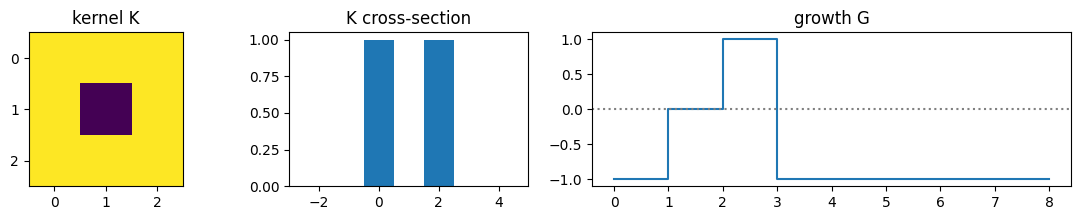

In [7]:
size = 64
np.random.seed(0)
A = np.random.randint(2, size=(size, size))
K = np.asarray([[1,1,1], [1,0,1], [1,1,1]])
K_sum = np.sum(K)
''' define growth function with growth/shrink ranges '''
def growth(U):
  return 0 + (U==3) - ((U<2)|(U>3))
def update(i):
  global A
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  ''' use incremental update and clipping '''
  #A = (A & (U==2)) | (U==3)
  A = np.clip(A + growth(U), 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth, K_sum=K_sum, bar_K=True)
fig = figure_world(A, cmap='binary')
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=50, interval=50).to_jshtml())

# Branching
After generalizing the Game of Life, we are now ready to extend it to continuous cases.

There are many possibile routes, here are two of them:

1. Game of Life → Larger-than-Life (continuous space)

2. Game of Life → Primordia (continuous states)

    2.1. Primordia → Lenia (continuous states-space-time)